# DCBC model evaluation

In [38]:

import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np
import os

figure_dir = f'{os.path.expanduser("~")}/Documents/figures_AtlasPaper/'

In [39]:
# Import symmetric evaluation
Sym = pd.read_csv(
    f'{ut.model_dir}/Models/Evaluation/eval_dataset7_sym.tsv', sep='\t')
Sym['symmetry'] = 'Symmetric'
Sym['train_data_string'] = Sym['train_data']
Sym['train_data'] = Sym['train_data'].apply(lambda x: x.split("' '"))


# Import asymmetric evaluation
Asym = pd.read_csv(
    f'{ut.model_dir}/Models/Evaluation/eval_dataset7_asym-hem.tsv', sep='\t')
Asym['symmetry'] = 'Asymmetric'

# Remove non-crossvalidated tests
Asym['train_data_string'] = Asym['train_data']
Asym['train_data'] = Asym['train_data'].apply(lambda x: x.split("', '"))
# Remove brackets and quotation marks from train_data
for i, row in Asym.iterrows():
    for j, train_data in enumerate(row['train_data']):
        train_data = train_data.replace('[', '')
        train_data = train_data.replace(']', '')
        train_data = train_data.replace("'", '')
        Asym.at[i, 'train_data'][j] = train_data

for i, row in Asym.iterrows():
    if row['test_data'] in row['train_data'] and not len(row['train_data']) == 7:
        Asym.drop(i, inplace=True)

Asym.head(140).tail(20)


# # Asym = Asym[~Asym.apply(lambda x: x['test_data'] in x['train_data'], axis=1)]


,model_name,atlas,K,train_data,train_loglik,subj_num,common_kappa,dcbc_group,dcbc_indiv,model_type,test_sess,indivtrain_ind,indivtrain_val,test_data,symmetry,train_data_string
120,sym_De,MNISymC3,10,[Demand],120993.1875,4,True,0.153850,0.232661,Models_03,all,half,2,WMFS,Asymmetric,['Demand']
121,sym_De,MNISymC3,10,[Demand],120993.1875,5,True,0.159583,0.201627,Models_03,all,half,2,WMFS,Asymmetric,['Demand']
122,sym_De,MNISymC3,10,[Demand],120993.1875,6,True,0.145732,0.170626,Models_03,all,half,2,WMFS,Asymmetric,['Demand']
123,sym_De,MNISymC3,10,[Demand],120993.1875,7,True,0.061606,0.165019,Models_03,all,half,2,WMFS,Asymmetric,['Demand']
124,sym_De,MNISymC3,10,[Demand],120993.1875,8,True,0.041606,0.091571,Models_03,all,half,2,WMFS,Asymmetric,['Demand']
125,sym_De,MNISymC3,10,[Demand],120993.1875,9,True,0.078212,0.155791,Models_03,all,half,2,WMFS,Asymmetric,['Demand']
126,sym_De,MNISymC3,10,[Demand],120993.1875,10,True,0.077742,0.154338,Models_03,all,half,2,WMFS,Asymmetric,['Demand']
127,sym_De,MNISymC3,10,[Demand],120993.1875,11,True,0.037579,0.062873,Models_03,all,half,2,WMFS,Asymmetric,['Demand']
128,sym_De,MNISymC3,10,[Demand],120993.1875,12,True,0.060138,0.069921,Models_03,all,half,2,WMFS,Asymmetric,['Demand']
129,sym_De,MNISymC3,10,[Demand],120993.1875,13,True,0.133541,0.205053,Models_03,all,half,2,WMFS,Asymmetric,['Demand']


In [40]:
Data = pd.concat([Sym, Asym], axis=0)

# Loop through rows and add indicator for those where train_data list is of length 6
Data['train_data_len'] = Data['train_data'].apply(lambda x: len(x))
# Make Training column 'Single' if train_data_len is 1, 'All' if train_data_len is 7 and 'Leave_one_out' if train_data_len is 6
Data['Training'] = Data['train_data_len'].apply(
    lambda x: 'Single' if x == 1 else 'Leave_one_out')
Data.loc[Data['train_data_len'] == 7, 'Training'] = 'All'
Data.loc[Data['train_data_len'] == 6, 'train_data_string'] = 'Leave_one_out'
Data.loc[Data['train_data_len'] == 7, 'train_data_string'] = 'All'




In [49]:
# Show rows where K is 14
Data[Data['K'] == 28]

,model_name,atlas,K,train_data,train_loglik,test_data,indivtrain_ind,indivtrain_val,subj_num,common_kappa,...,session,coserr_group,coserr_floor,coserr_ind2,coserr_ind3,symmetry,train_data_string,test_sess,train_data_len,Training


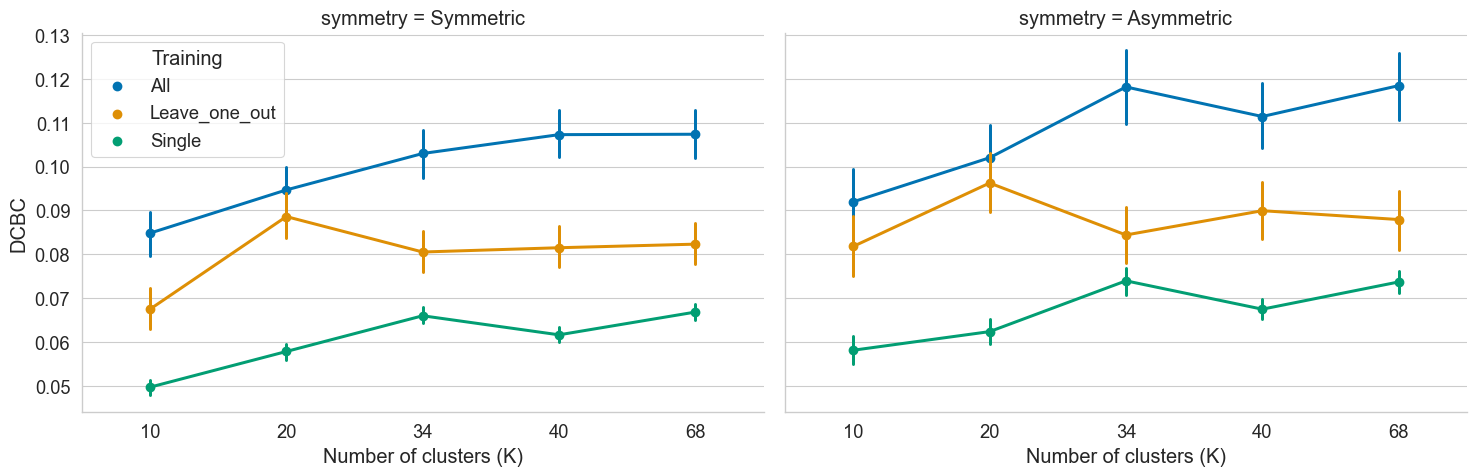

In [41]:
# Plot dcbc_group as a function of K with Hue = Training (# Plot only Ks where Symmetric and Asymmetric models have a value))
g = sb.catplot(x='K', y='dcbc_group', hue='Training', data=Data[Data['K'].isin([10, 20, 34, 40, 68, ])], kind='point', col='symmetry',
                palette='colorblind', height=5, aspect=1.5, legend_out=False)
g.set_axis_labels('Number of clusters (K)', 'DCBC')
g._legend.set_title('Training')
# plt.savefig(f'{ut.model_dir}/Figures/DCBC/DCBC_group.png', dpi=300)



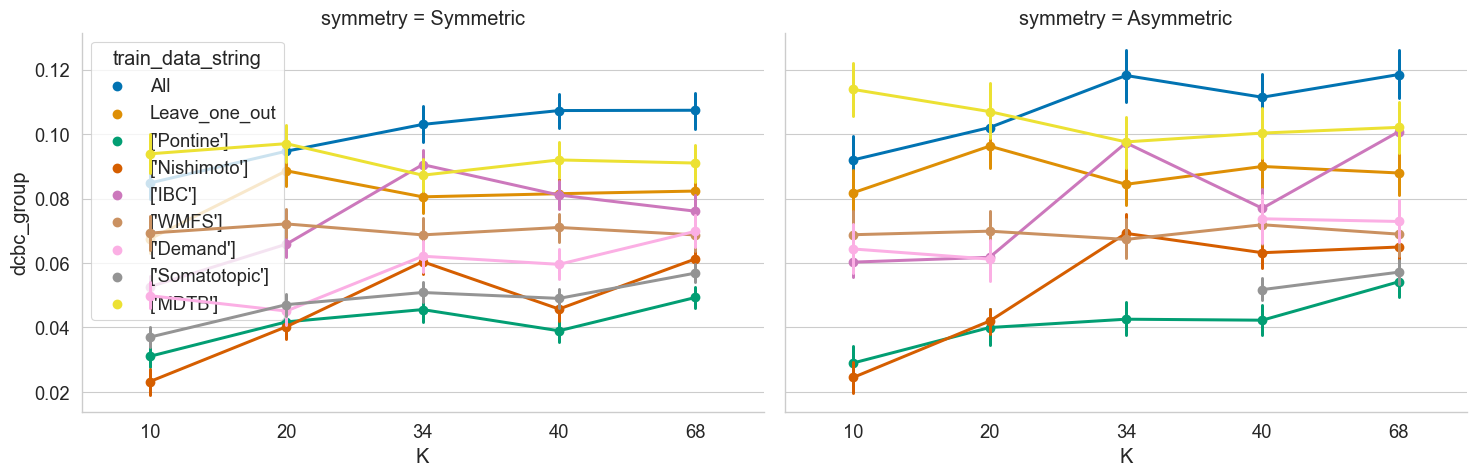

In [42]:
Data[(Data['symmetry'] == 'Asymmetric') & (Data['K'] == 10)
     & (Data['train_data_len'] == 1)].head(10)
g = sb.catplot(x='K', y='dcbc_group', hue='train_data_string', data=Data[Data['K'].isin([10, 20, 34, 40, 68, ])], kind='point', col='symmetry', 
               palette='colorblind', height=5, aspect=1.5, legend_out=False)


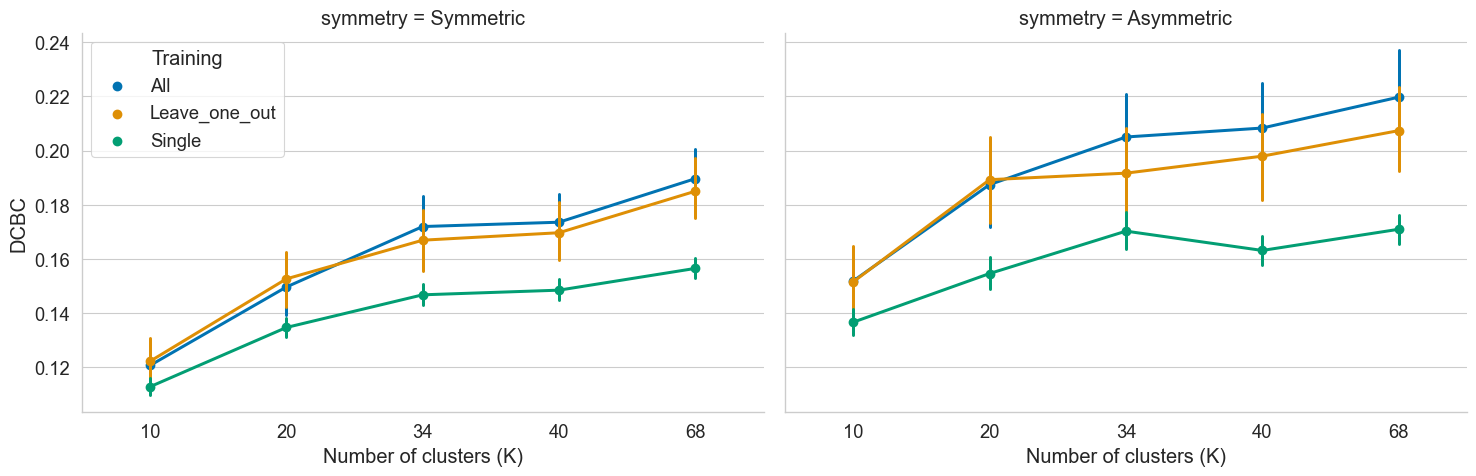

In [43]:
# Same plot for dcbc_individual
g = sb.catplot(x='K', y='dcbc_indiv', hue='Training', data=Data[Data['K'].isin([10, 20, 34, 40, 68, ])], kind='point', col='symmetry',
                palette='colorblind', height=5, aspect=1.5, legend_out=False)
g.set_axis_labels('Number of clusters (K)', 'DCBC')
g._legend.set_title('Training')
# plt.savefig(f'{ut.model_dir}/Figures/DCBC/DCBC_individual.png', dpi=300)

<Figure size 1000x1000 with 0 Axes>

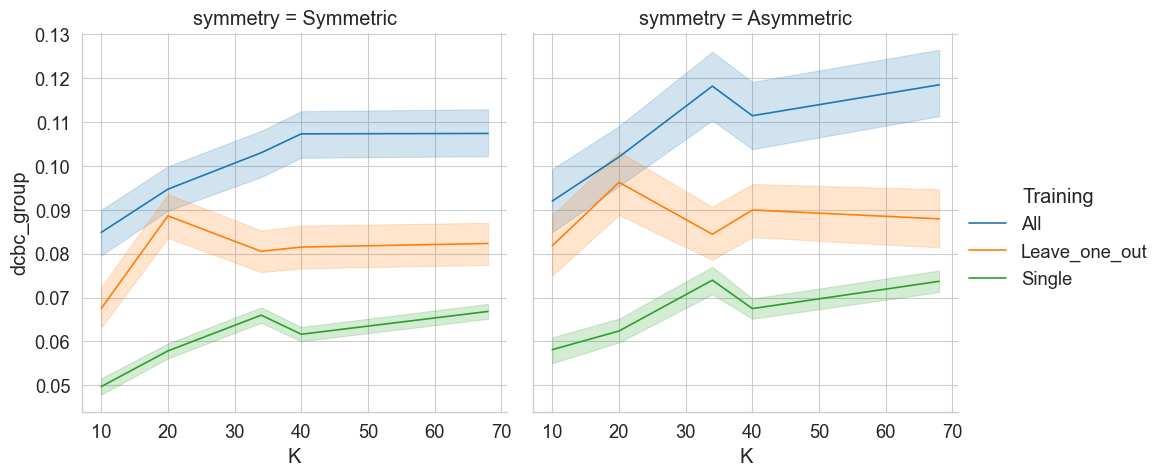

In [47]:
figsize = (10, 10)
plt.figure(figsize=figsize)
sb.relplot(
    data=Data[Data['K'].isin([10, 20, 34, 40, 68, ])], x="K", y="dcbc_group", hue="Training", kind="line", col="symmetry", markers=True)
# plt.savefig(f'{figure_dir}/DCBC_group.pdf')

<Figure size 1000x500 with 0 Axes>

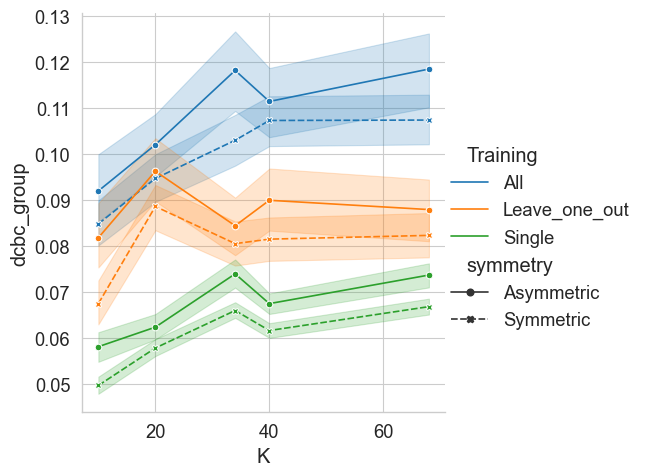

<Figure size 1000x500 with 0 Axes>

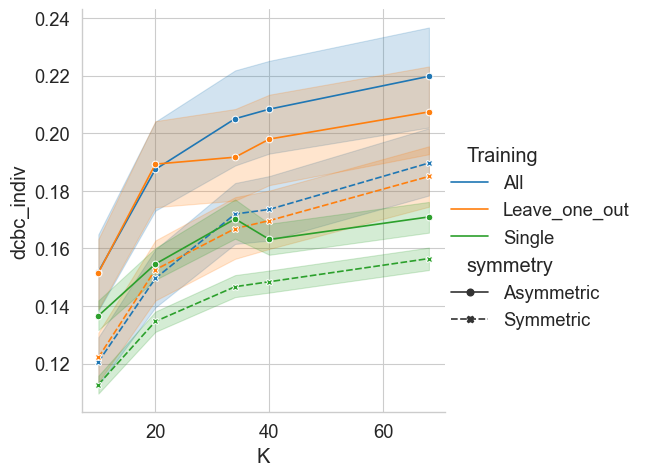

In [45]:
figsize=(10, 5)
plt.figure(figsize=figsize)
sb.relplot(
    data=Data[Data['K'].isin([10, 20, 34, 40, 68, ])], x="K", y="dcbc_group", hue="Training", kind="line", style="symmetry", markers=True, style_order=['Asymmetric', 'Symmetric'])
# plt.savefig(f'{figure_dir}/DCBC_group_hue-symmetry.pdf')    

plt.figure(figsize=figsize)
sb.relplot(
    data=Data[Data['K'].isin([10, 20, 34, 40, 68, ])], x="K", y="dcbc_indiv", hue="Training", kind="line", style="symmetry", markers=True, style_order=['Asymmetric', 'Symmetric'])
# plt.savefig(f'{figure_dir}/DCBC_individual_hue-symmetry.pdf')


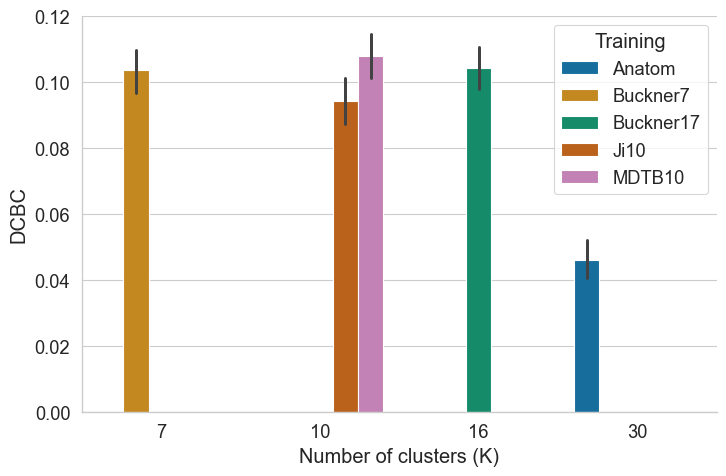

In [37]:
# Import existing data
Existing = pd.read_csv(
    f'{ut.model_dir}/Models/Evaluation/eval_all_5existing_on_taskDatasets.tsv', sep='\t')

# Plot dcbc_group as a function of K with Hue
sb.set_style('whitegrid')
sb.set_context('paper', font_scale=1.5)
g = sb.catplot(x='K', y='dcbc_group', hue='train_data', data=Existing, kind='bar',
                palette='colorblind', height=5, aspect=1.5, legend_out=False)
g.set_axis_labels('Number of clusters (K)', 'DCBC')
g._legend.set_title('Training')

